<a href="https://colab.research.google.com/github/Carol-Coutinho/OU3/blob/main/AVS04_OU3_Caroline_Coutinho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AVS 04

Caroline Coutinho

Para o mesmo sistema, componentes e condições que foi usado na AVS03, usar o método Ponchon-Savarit determinando:
- razão de refluxo mínima
- NETS mínimo
- NETS para R_D = 1.3 * R_D_min
- carga térmica do condensador
- carga térmica do refervedor
- verificação do BEG
- comparação em uma tabela com os resultados do método McCabe-Thiele

Componentes: Benzeno e Tolueno

## Parte 1:

Preparação dos dados dos componentes do sistema.

In [ ]:
# Preparando kernel
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Para ler/carregar
with open('databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)

In [ ]:
# Carregamento das funções úteis
from OU3_funcoes_uteis_v01 import *

In [ ]:
#Conhecendo o banco de dados:

dados.columns

Index(['num', 'name', 'molar_mass', 'fusion_point', 'boiling_point',
       'critical_temp', 'critical_pressure', 'critical_volume', 'zc',
       'acentric_factor', 'liq_density', 'temp_ref_liq_density',
       'dipole_moment', 'cp_a', 'cp_b', 'cp_c', 'cp_d', 'visc_b', 'visc_c',
       'delta_h0f_gas', 'delta_g0f_gas', 'pvap_a', 'pvap_b', 'pvap_c',
       'temp_max_pvap', 'temp_min_pvap', 'pvap_h_a', 'pvap_h_b', 'pvap_h_c',
       'pvap_h_d', 'delta_h_vap_bp'],
      dtype='object')

Iremos precisar dos números referentes aos nossos componentes, temperaturas de ebulição e do Delta H de vap.

In [ ]:
# Procurando os componentes: 
dados[dados.name.str.contains('toluene', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,liq_density,temp_ref_liq_density,dipole_moment,cp_a,cp_b,cp_c,cp_d,visc_b,visc_c,delta_h0f_gas,delta_g0f_gas,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
440,286,TOLUENE,92.141,178.0,383.8,591.7,40.6,316.0,0.264,0.257,0.867,293.0,0.4,-5.817,0.1224,-0.000066,1.173000e-08,467.33,255.24,11.95,29.16,16.0137,3096.52,-53.67,410.0,280.0,56.785,-6283.5,-5.681,4.84,7930.0


In [ ]:
dados[dados.name.str.contains('BENZENE', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,liq_density,temp_ref_liq_density,dipole_moment,cp_a,cp_b,cp_c,cp_d,visc_b,visc_c,delta_h0f_gas,delta_g0f_gas,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
14,383,"1,2,3-TRIMETHYLBENZENE",120.195,247.7,449.2,664.5,34.1,430.0,0.270,0.390,0.894,293.0,0.6,-1.658000,0.151300,-0.000079,1.579000e-08,NaN,NaN,-2.29,29.77,16.2121,3670.22,-66.07,479.00,329.0,NaN,NaN,NaN,NaN,9570.0
16,384,"1,2,4-TRIMETHYLBENZENE",120.195,227.0,442.5,649.1,31.9,430.0,0.258,0.390,0.880,289.0,0.3,-1.115000,0.149000,-0.000078,1.523000e-08,872.74,297.75,-3.33,27.95,16.2190,3622.58,-64.59,471.00,324.0,56.241,-7256.56,-5.459,7.270,9380.0
24,385,"1,3,5-TRIMETHYLBENZENE",120.195,228.4,437.9,637.3,30.9,433.0,0.260,0.398,0.865,293.0,0.1,-4.679000,0.160600,-0.000088,1.839000e-08,437.52,268.27,3.84,28.19,16.2893,3614.19,-63.57,466.00,321.0,58.041,-7326.78,-5.706,7.220,9330.0
28,407,"1,4-DIETHYLBENZENE",134.222,231.0,456.9,657.9,27.7,480.0,0.250,0.403,0.862,293.0,0.1,-8.937000,0.207100,-0.000133,3.370000e-08,NaN,NaN,-5.32,32.95,16.1140,3657.22,-71.18,487.00,335.0,NaN,NaN,NaN,NaN,9410.0
45,380,1-METHYL-2-ETHYLBENZENE,120.195,192.3,438.3,651.0,30.0,460.0,0.260,0.294,0.881,293.0,0.0,-3.928000,0.167100,-0.000098,2.228000e-08,NaN,NaN,0.29,31.33,16.1253,3535.33,-65.85,467.00,321.0,64.337,-7662.94,-6.617,7.180,9290.0
46,404,1-METHYL-2-ISOPROPYLBENZENE,134.222,NaN,451.5,670.0,28.6,NaN,NaN,0.277,0.876,293.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,15.9809,3564.52,-70.00,481.00,330.0,NaN,NaN,NaN,NaN,0.0
47,405,1-METHYL-2-ISOPROPYLBENZENE,134.222,NaN,448.3,666.0,29.0,NaN,NaN,0.279,0.861,293.0,0.0,-11.646000,0.216500,-0.000145,3.887000e-08,NaN,NaN,-7.00,0.00,15.9811,3543.79,-69.22,478.00,328.0,67.726,-8033.58,-7.076,8.390,9110.0
48,381,1-METHYL-3-ETHYLBENZENE,120.195,177.6,434.5,637.0,28.0,490.0,0.260,0.360,0.865,293.0,0.0,-6.926000,0.174200,-0.000104,2.388000e+00,8.00,0.00,0.00,-0.46,30.2200,16.15,3521.08,-64.64,463.0,318.000,65.67,-7678.110,-6.815,7.2
49,382,1-METHYL-4-ETHYLBENZENE,120.195,210.8,435.2,640.0,29.0,470.0,0.260,0.322,0.861,293.0,0.0,-6.523000,0.171400,-0.000101,2.279000e-08,463.17,266.08,-0.49,30.28,16.1135,3516.31,-64.23,463.00,318.0,61.404,-7422.59,-6.212,7.230,9180.0
50,406,1-METHYL-4-ISOPROPYLBENZENE,134.222,200.0,450.3,653.0,27.9,NaN,NaN,0.371,0.857,293.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,15.9424,3539.21,-70.10,480.00,329.0,63.225,-7800.97,-6.432,8.410,0.0


In [ ]:
# Seleção dos componentes presentes no sistema (Benzeno e Tolueno)
lista_componentes = [242, 286]
nc = len(lista_componentes)
nc

2

In [ ]:
# Verificando os pontos de ebulição de nossos componentes:
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[353.3, 383.8]

In [ ]:
z = [0.5,0.5]

In [ ]:
K_comp = f_K_Raoult_db(370.0, 760, lista_componentes, dados)[0]
K_comp # benzeno é o componente mais volátil

array([1.63010412, 0.66463997])

## PARTE 2: Diagrma Entalpia - Composição

In [ ]:
# Verificando os Delta H de vaporização de nossos componentes:
Delta_h_vap = dados[dados['num'].isin(lista_componentes)]['delta_h_vap_bp']
Delta_h_vap = Delta_h_vap.tolist()
Delta_h_vap


[7352.0, 7930.0]

In [ ]:
T_faixa = np.linspace(T_eb_comp[0], T_eb_comp[1], 10)
T_faixa

array([353.3       , 356.68888889, 360.07777778, 363.46666667,
       366.85555556, 370.24444444, 373.63333333, 377.02222222,
       380.41111111, 383.8       ])

Cálculo das entalpias de vapor para cada temperatura

In [ ]:
# Função para calculo de Cp

def f_cp_vap(Temp,param):
    '''Função que calcula cp do vapor como  gás ideal para os dados do 
        databank_properties.pickle
    '''
    a = param[0]
    b = param[1]
    c = param[2]
    d = param[3]
    cp = a + b*Temp + c*Temp**2 + d*Temp**3
    # attr(x = cp, which = "units") <- "cal/mol_K"
    cp = 4.184 * cp # conversão de cal para J (Joules)
    #cp = 1000.0 * cp # conversão de mol para kmol
    return cp # J/mol/K

In [ ]:
param = dados [dados['num'] == lista_componentes[0]][['cp_a', 'cp_b', 'cp_c', 'cp_d']]
param = param.to_numpy()[0]
param

array([-4.093413e-01,  7.762383e-02, -2.643033e-05,  4.404292e-21])

In [ ]:
def f_cp_param(T1, lista_componentes, dados):
    '''Função que monta uma matriz com os parâmetros de todos os compoenente da 
        lista_componentes e também calcula o valor de cp de cada um deles na 
        temperatura T1
        Entradas:
        T1 = temperatura em K
        lista_componentes =
        dados =
        Saidas:
        v_cp = vetor com os valores de cp @T1 em J/mol/K
        M_param = matriz com os quatro parâmetrso da equação do modelo de cp, sendo um
                  componente por linha na mesma ordem de lista_componentes
        '''
    nc = len(lista_componentes)
    M_param = np.empty((nc,4))
    v_cp = np.empty((nc))
    k = 0
    for i_num in lista_componentes:
        #print(i_num)
        param = dados [dados['num'] == i_num][['cp_a', 'cp_b', 'cp_c', 'cp_d']]
        param = param.to_numpy()[0]
        M_param[k,:] = param
        v_cp[k] = f_cp_vap(T1,param)
        k += 1
    return (v_cp, M_param)

In [ ]:
import scipy.integrate as integrate

In [ ]:
T1 = 298.15
T2 = T_faixa

In [ ]:
P_eq = 760.0 # mmHg

In [ ]:
x_eq, y_eq = f_sol_ELV_2c_db(T_faixa[1], P_eq, lista_componentes, dados)

In [ ]:
def f_gerar_dados_elv_2c_bd(P_eq, n_pontos, lista_componentes, dados):
    T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
    T_eb_comp = T_eb_comp.tolist()
    T_faixa = np.linspace(T_eb_comp[0], T_eb_comp[1], n_pontos)
    dados_elv = pd.DataFrame({'T': T_faixa})
    for i, T in enumerate(dados_elv['T']):
        x_eq, y_eq = f_sol_ELV_2c_db(T, P_eq, lista_componentes, dados)
        dados_elv.loc[i,'x1'] = x_eq[0]
        dados_elv.loc[i,'y1'] = y_eq[0]
    return dados_elv

In [ ]:
n_pontos = 20
dados_elv = f_gerar_dados_elv_2c_bd(P_eq, n_pontos, lista_componentes, dados)
dados_elv

,T,x1,y1
0,353.300000,0.997594,0.999073
1,354.905263,0.919455,0.967221
2,356.510526,0.845267,0.933503
3,358.115789,0.774777,0.897847
4,359.721053,0.707747,0.860182
5,361.326316,0.643960,0.820431
6,362.931579,0.583212,0.778520
7,364.536842,0.525315,0.734368
8,366.142105,0.470092,0.687896
9,367.747368,0.417380,0.639022


In [ ]:
M_param = f_cp_param(T1, lista_componentes, dados)[1]
M_param[0,:]

array([-4.093413e-01,  7.762383e-02, -2.643033e-05,  4.404292e-21])

In [ ]:
# Loop para calcular cada entalpia em cada tmeperatura
Delta_H = []
for i in list(dados_elv['T']):
  T2 = float(i)
  u = integrate.quad(f_cp_vap, T1, T2, args =(M_param[0,:],))[0]
  Delta_H.append(u)
Delta_H

[5091.170950094606,
 5250.775892890581,
 5411.015477649807,
 5571.888789494728,
 5733.39491354779,
 5895.53293493144,
 6058.301938768123,
 6221.70101018029,
 6385.729234290382,
 6550.385696220852,
 6715.669481094134,
 6881.579674032688,
 7048.1153601589585,
 7215.275624595388,
 7383.059552464423,
 7551.466228888514,
 7720.494738990101,
 7890.144167891637,
 8060.413600715565,
 8231.302122584331]

In [ ]:
x_stream = np.array([0.5, 0.5])
x_stream

array([0.5, 0.5])

In [ ]:
DH = np.empty((nc,))
for i in range(nc):
    print(i)
    DH[i] = integrate.quad(f_cp_vap, T1, T2, args =(M_param[i,:],))[0]
DH

0
1


array([ 8231.30212258, 10274.55559464])

In [ ]:
H_stream = x_stream @ DH
H_stream

9252.9288586135

In [ ]:
def f_H_vap_ig_stream(y_stream, T_ref, Temp, lista_componentes, dados):
    nc = len(lista_componentes)
    M_param = f_cp_param(T_ref, lista_componentes, dados)[1]
    DH = np.empty((nc,))
    for i in range(nc):
        DH[i,] = integrate.quad(f_cp_vap, T_ref, Temp, args =(M_param[i,:],))[0]
    H_stream = y_stream @ DH
    return (H_stream, DH)

In [ ]:
f_H_vap_ig_stream(x_stream, T1, T2, lista_componentes, dados)

(9252.9288586135, array([ 8231.30212258, 10274.55559464]))

In [ ]:
Delta_Hv = []
for i in list(dados_elv['T']):
  T2 = float(i)
  u = f_H_vap_ig_stream(x_stream, T1, T2, lista_componentes, dados)
  Delta_Hv.append(u)
Delta_Hv

[(5710.932809111231, array([5091.17095009, 6330.69466813])),
 (5890.689213388202, array([5250.77589289, 6530.60253389])),
 (6071.193931249513, array([5411.01547765, 6731.37238485])),
 (6252.445578748659, array([5571.88878949, 6933.002368  ])),
 (6434.442772916815, array([5733.39491355, 7135.49063229])),
 (6617.184131762831, array([5895.53293493, 7338.83532859])),
 (6800.668274273236, array([6058.30193877, 7543.03460978])),
 (6984.893820412244, array([6221.70101018, 7748.08663064])),
 (7169.859391121736, array([6385.72923429, 7953.98954795])),
 (7355.563608321278, array([6550.38569622, 8160.74152042])),
 (7542.005094908107, array([6715.66948109, 8368.34070872])),
 (7729.1824747571545, array([6881.57967403, 8576.78527548])),
 (7917.094372721016, array([7048.11536016, 8786.07338528])),
 (8105.739414629966, array([7215.2756246 , 8996.20320466])),
 (8295.116227291961, array([7383.05955246, 9207.17290212])),
 (8485.223438492634, array([7551.46622889, 9418.9806481 ])),
 (8676.059676995295, ar

In [ ]:
DH_v = []
for row in Delta_Hv:
  valor=row[0]
  DH_v.append(valor)
DH_v

[5710.932809111231,
 5890.689213388202,
 6071.193931249513,
 6252.445578748659,
 6434.442772916815,
 6617.184131762831,
 6800.668274273236,
 6984.893820412244,
 7169.859391121736,
 7355.563608321278,
 7542.005094908107,
 7729.1824747571545,
 7917.094372721016,
 8105.739414629966,
 8295.116227291961,
 8485.223438492634,
 8676.059676995295,
 8867.623572540935,
 9059.913755848225,
 9252.9288586135]

Para o cálculo do H_l temos:

$$ H_l = H_v - H_{vap} $$

In [ ]:
Delta_Hl = []
k=0
for i in DH_v:
  Delta_Hv = float(i)
  u = DH_v[k] - Delta_h_vap[0]
  Delta_Hl.append(u)
  k+=1
DH_L = Delta_Hl
DH_L

[-1641.067190888769,
 -1461.310786611798,
 -1280.8060687504867,
 -1099.5544212513414,
 -917.5572270831854,
 -734.8158682371686,
 -551.3317257267636,
 -367.10617958775583,
 -182.14060887826417,
 3.56360832127757,
 190.0050949081069,
 377.1824747571545,
 565.094372721016,
 753.7394146299657,
 943.116227291961,
 1133.2234384926342,
 1324.0596769952954,
 1515.6235725409351,
 1707.9137558482253,
 1900.9288586135008]

In [ ]:
# Fazendo o data frame:

H_v_f = np.array(DH_v,ndmin=1)
H_L_f = np.array(DH_L,ndmin=1)

In [ ]:
H_L_f = np.reshape(H_L_f,(20,1))
H_v_f = np.reshape(H_v_f,(20,1))

In [ ]:
dados_elv["H_V"]=H_v_f
dados_elv["H_L"]=H_L_f

In [ ]:
dados_elv

,T,x1,y1,H_V,H_L
0,353.300000,0.997594,0.999073,5710.932809,-1641.067191
1,354.905263,0.919455,0.967221,5890.689213,-1461.310787
2,356.510526,0.845267,0.933503,6071.193931,-1280.806069
3,358.115789,0.774777,0.897847,6252.445579,-1099.554421
4,359.721053,0.707747,0.860182,6434.442773,-917.557227
5,361.326316,0.643960,0.820431,6617.184132,-734.815868
6,362.931579,0.583212,0.778520,6800.668274,-551.331726
7,364.536842,0.525315,0.734368,6984.893820,-367.106180
8,366.142105,0.470092,0.687896,7169.859391,-182.140609
9,367.747368,0.417380,0.639022,7355.563608,3.563608


Plotando os dados o gráfico da entalpia x composição:

In [ ]:
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x7fdd76fc7850>,
 <a list of 13 Text major ticklabel objects>)

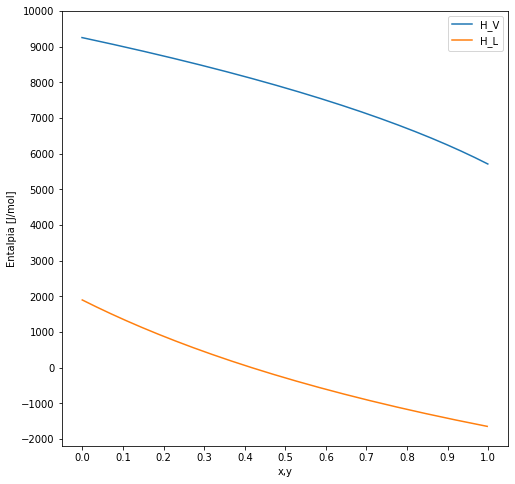

In [ ]:
fig1, ax1 = plt.subplots( figsize =(8,8))
ax1.plot(dados_elv['y1'], dados_elv['H_V'],label='H_V')
ax1.plot(dados_elv['x1'], dados_elv['H_L'],label='H_L')
# Adicionando texto nos eixos - descrição
ax1.set_xlabel('x,y')
ax1.set_ylabel('Entalpia [J/mol]')
ax1.legend()
plt.xticks(np.arange(0, 1.05, 0.1))
plt.yticks(np.arange(-2000, 11000 , 1000))

([<matplotlib.axis.YTick at 0x7fdd77201150>,
 <a list of 48 Text major ticklabel objects>)

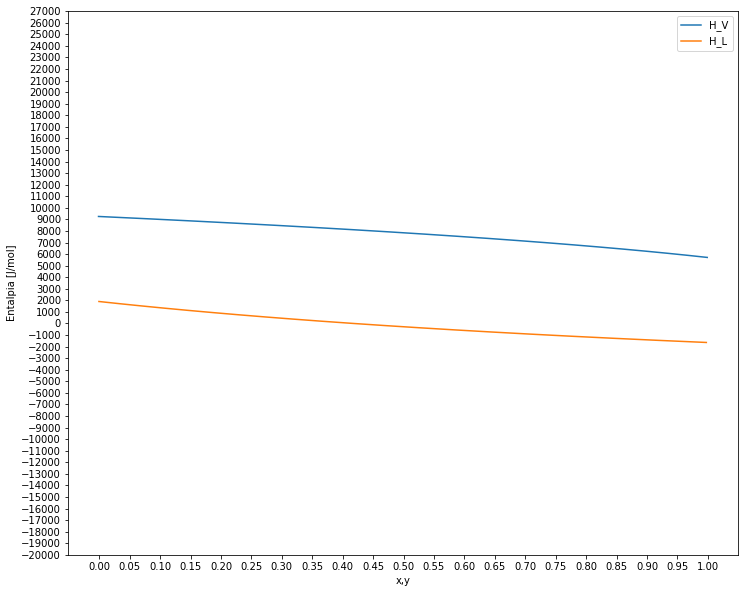

In [ ]:
fig1, ax1 = plt.subplots( figsize =(12,10))
ax1.plot(dados_elv['y1'], dados_elv['H_V'],label='H_V')
ax1.plot(dados_elv['x1'], dados_elv['H_L'],label='H_L')
# Adicionando texto nos eixos - descrição
ax1.set_xlabel('x,y')
ax1.set_ylabel('Entalpia [J/mol]')
ax1.legend()
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(-20000, 28000 , 1000))

## Parte 3: Razão de Refluxo mínima

**Encontrando $P_D^{min}$**

A partir do ponto de Pinch encontrado na AVS03, podemos definir nosso $y^{pinch}$ e nosso $x^{pinch}$ :

$y^{pinch} = 0,63 $

$x^{pinch} = 0,405 $

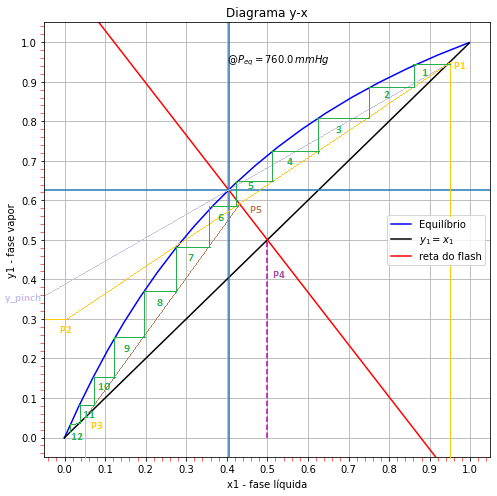

Como a carga no topo é de 95% molar, $x_1^D = 0,95$

Pd_min = 1900 J/mol

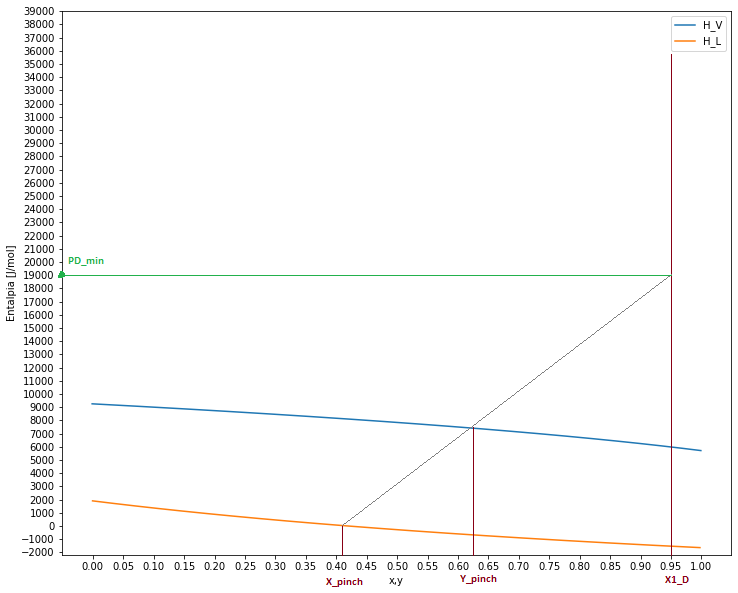

In [ ]:
Pd_min = 19000

Fazendo o cálculo do Hv1:

Sabemos que no topo temos um vapor saturado e portanto a temperatura será a temperatura do ponto de bolha na composição x_d = 0.95. 

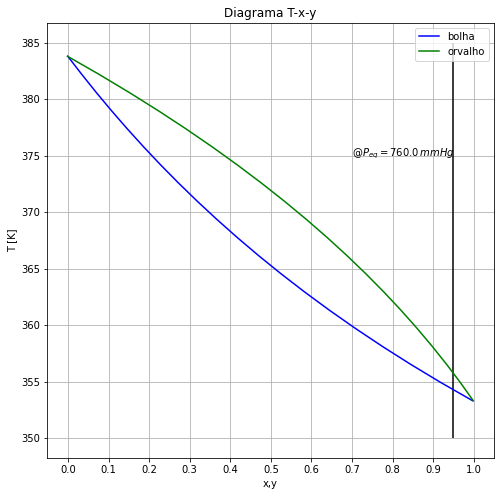

In [ ]:
# Fazendo o gráfico
fig1, ax1 = plt.subplots( figsize =(8,8))
ax1.plot(dados_elv['x1'], dados_elv['T'], 'b', label='bolha')
ax1.plot(dados_elv['y1'], dados_elv['T'], 'g', label='orvalho')
#ax1.plot(C_A_eq_teste[:,0], q_A_prev, 'r-', label='mod')
# Adicionando texto nos eixos - descrição
ax1.set_xlabel('x,y')
ax1.set_ylabel('T [K]')
# Adicionando título para a figura
ax1.set_title('Diagrama T-x-y')
# Adicionando um texto
ax1.text(0.7, 375, r'@$P_{eq} = 760.0 \, mmHg$')
# Adicionando uma legenda
ax1.legend()
ax1.grid()
plt.xticks(np.arange(0, 1.05, 0.1))
ax1.vlines(0.95, 350, 385)

Rebatendo o ponto de x1_d da curva de orvalho no eixo y, econtramos nossa temperatura do vapor saturado.

T_v_sat = 356ºC

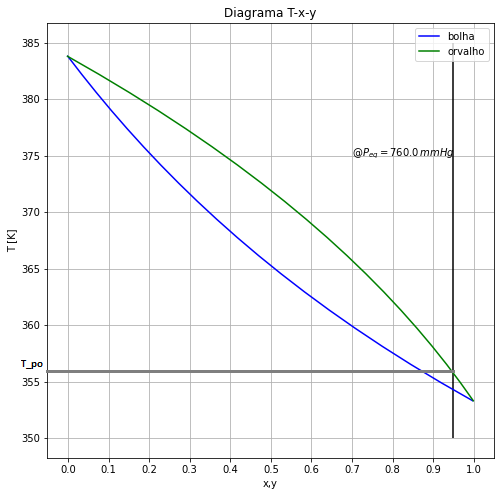

In [ ]:
t_v_sat = 356


In [ ]:
# Calculando a entalpia:
H1_v = integrate.quad(f_cp_vap, T1, t_v_sat, args =(M_param[0,:],))[0] # componente 1 -> mais volátil
H1_v # J/mol

5359.985268471892

Agora iremos calcular o Hd_L. Para isso, iremos pegar a composição de x1_d = 0.95 no gráfico de entalpia, rebater na curva do H_l e em seguida rebatendo no eixo de entalpia. 

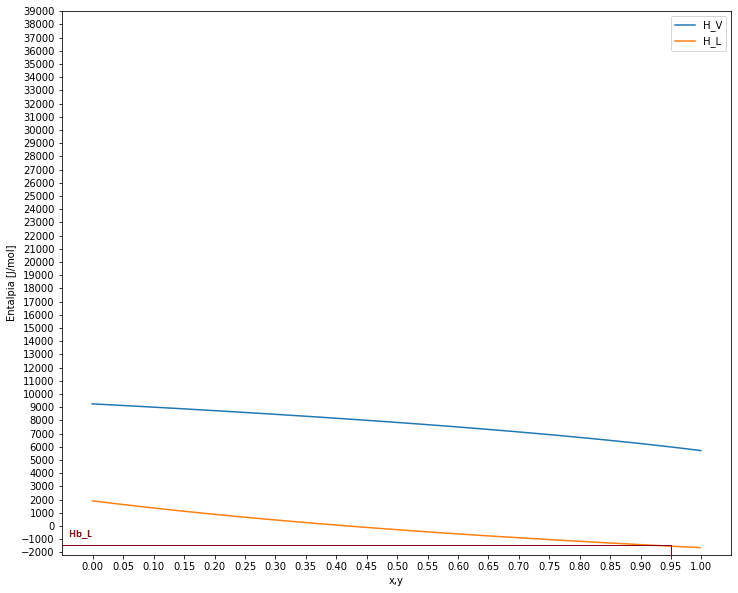

In [ ]:
Hd_l = -1500

Finalmente, iremos encontrar o Rd_min pela equação: 

$$ $R_D^{min} = (P_D^{min} - H_1^V)/(H_1^V - H_D^L)$ $$

In [ ]:
Rd_min = (Pd_min - H1_v)/(H1_v-Hd_l)
Rd_min

1.9883446097496524

## Parte 4: NETS Mínimo

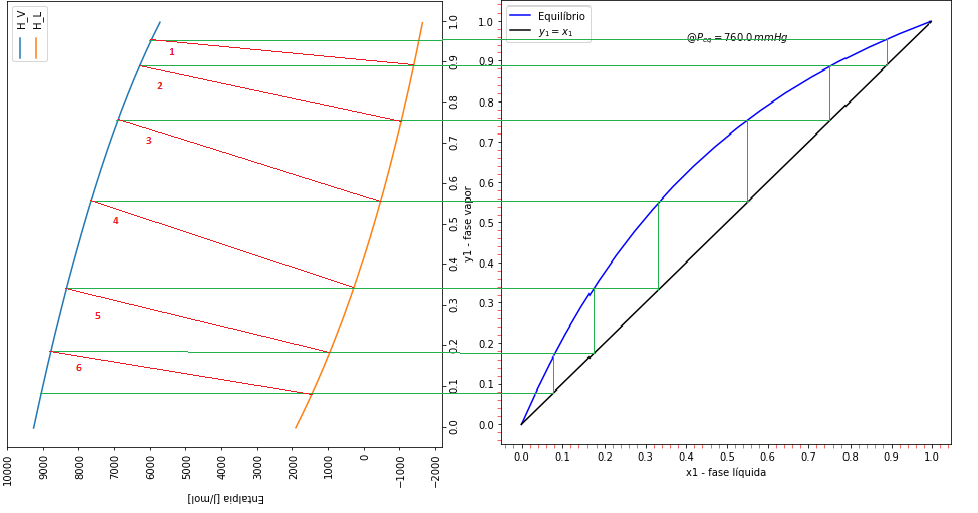

Encontramos 6 estágios mínimos. 

## Parte 4: NETS para R_D = 1.3 * R_D_min

In [ ]:
Rd = 1.3*Rd_min
Rd

2.5848479926745482

O Cálculo de PD será dado por: 

$P_D = R_D(H_1^V - H_o^L) + H_1^V$  

$H_o^l=H_D^L$


In [ ]:
# Calculando Pd: 

Pd = Rd*(H1_v-Hd_l) + H1_v
Pd

23092.004419458433

Agora iremos determinar o PB através do gráfico de entalpia: Ele será formado ao se traçar a reta entre PD e o ponto formado pela interceção de z e HF. 

Para encontrarmos HF precisamos da seguinte equação: 

$H_F = f_v \cdot H_F^V + (1 - f_v)H_F^L$

Onde:

$f_v = 0.43$ -> Valor encontrado na AVS03 sob as mesmas condições iniciais

$H_F^V$ é a entalpia rebatida no ponto de orvalho do gráfico, para o x de pinch

$H_F^L$ é a entalpia rebatida no ponto de ponto do gráfico, para o y de pinch

Determinando HF_v e HF_l:

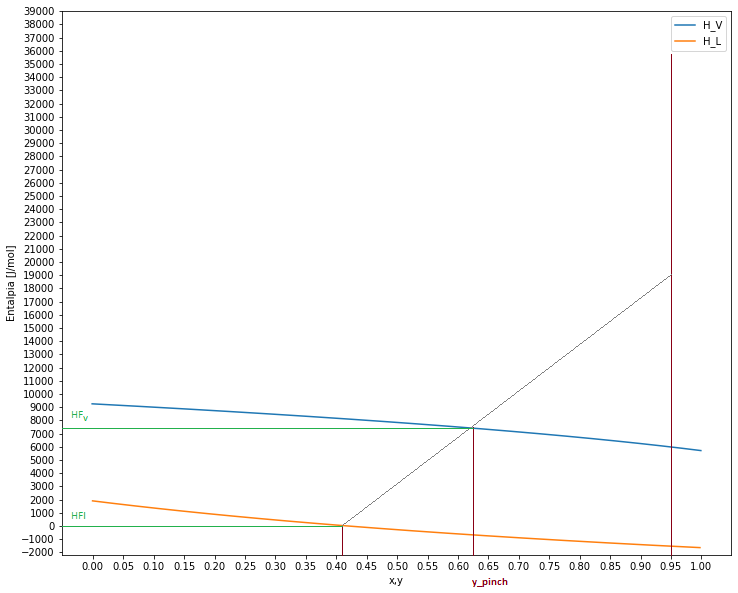

In [ ]:
HF_v = 7500
HF_l = 0
fv = 0.43 # resultado da AVS_03
HF = fv*HF_v + (1-fv)*HF_l
HF

3225.0

Traçando as retas temos: 

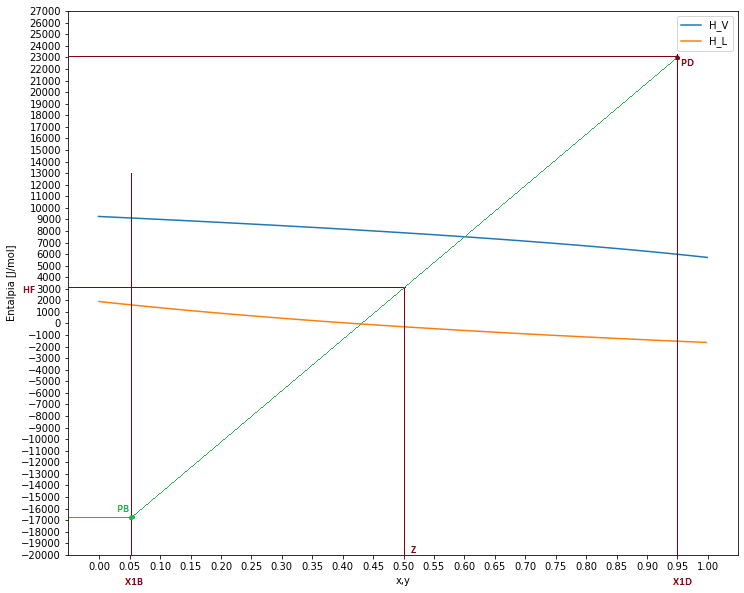

In [ ]:
Pb = -16800

Agora com os pontos de PD e PB determinados podemos traçar o gráfico para determinar o número de estágios.

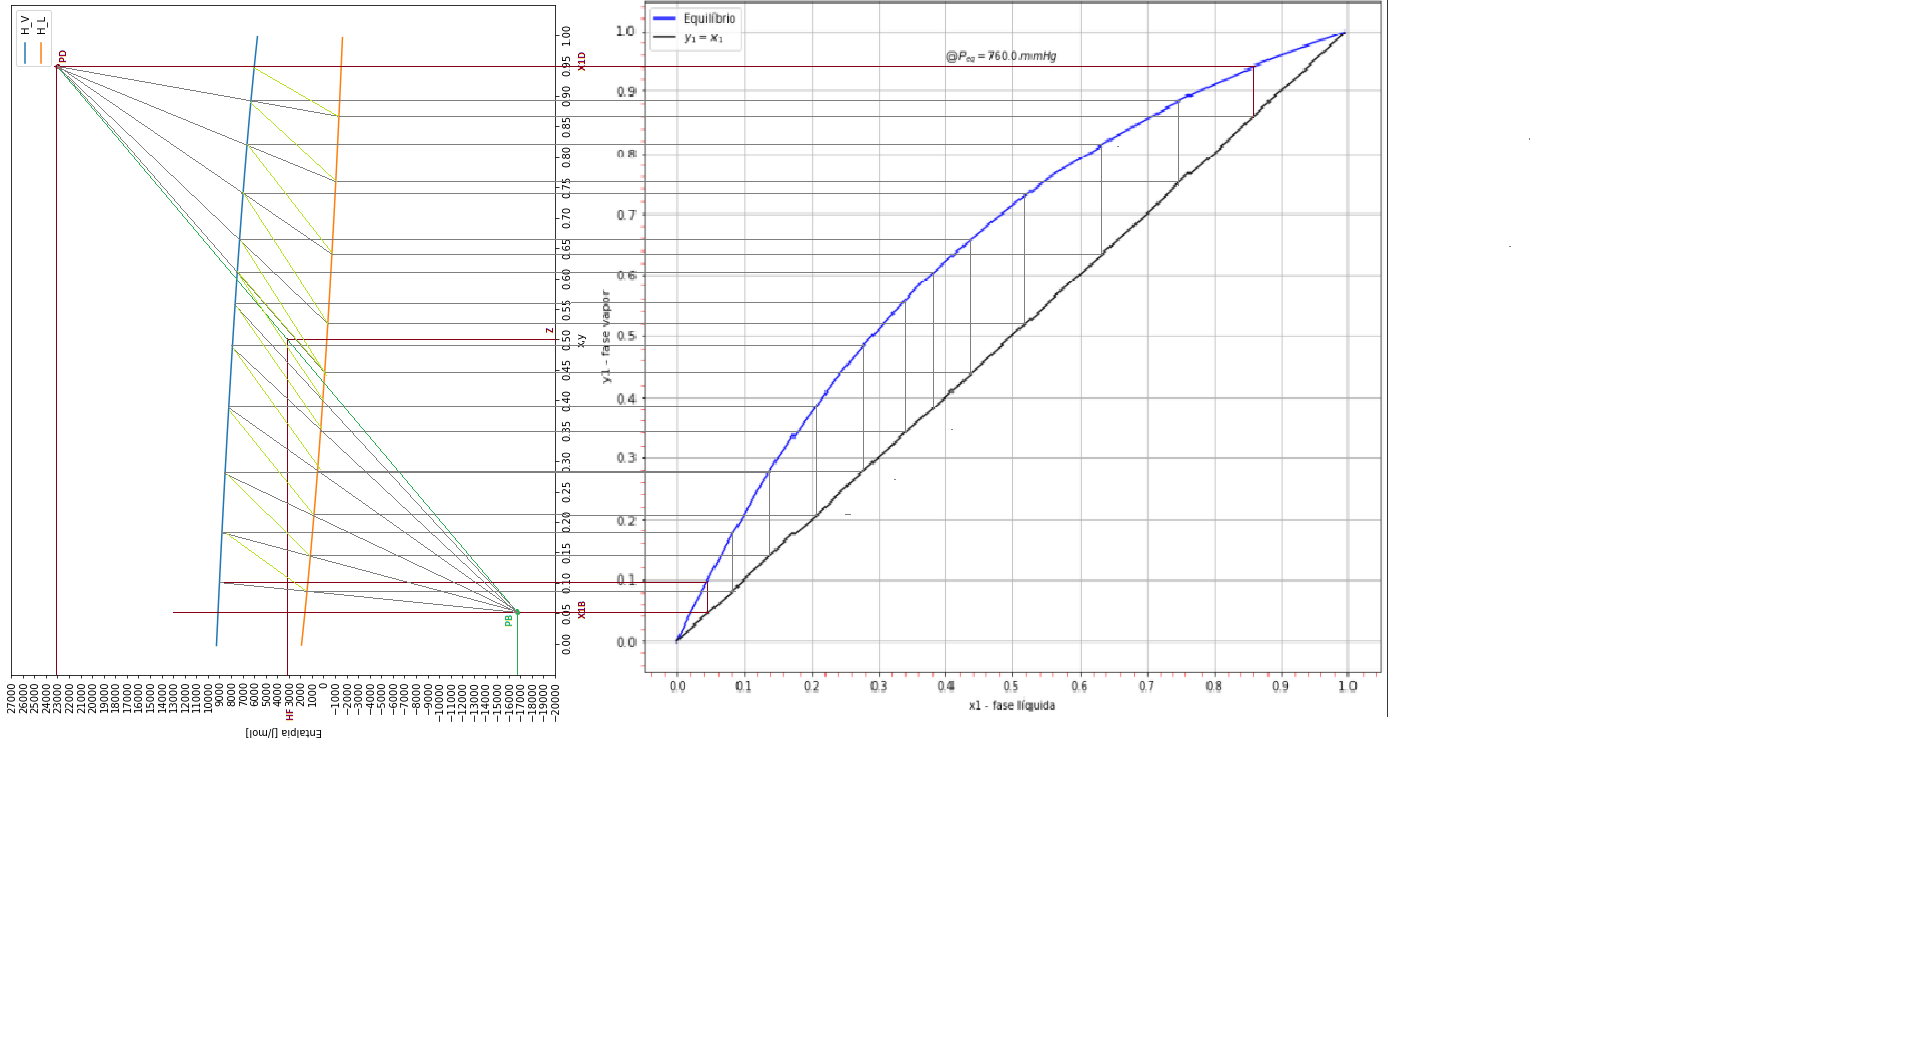

Contamos:

NETS = 11
Estágios de alimentação = 6

## Parte 5: Balanço de massa global para determinar D e B. 

Para isso iremos utilizar as equações: 

$ F  = D + B  $

$ Z_1 \cdot F  = x_1^D \cdot D + x_1^B \cdot B $

Resolvendo o sistema BMG:

$  x_1^D \cdot D + x_1^B \cdot B = Z_1 \cdot F$

$  1 \cdot D + 1 \cdot B= F$


In [ ]:
# Especificações da nossa destilação

F = 50 # kmo/h
x1_D = 0.95
x1_B = 0.05

In [ ]:
v_resul = np.array([z[0]*F,F])
v_resul

array([25., 50.])

In [ ]:
A_bmg = np.array([[x1_B,x1_D],
                  [1,1]])
                  
A_bmg

array([[0.05, 0.95],
       [1.  , 1.  ]])

In [ ]:
x_sol_bmg = np.linalg.inv(A_bmg) @ v_resul # multiplicando a matriz inversa pela B (matriz dos resultados)
x_sol_bmg # B e D respectivamente

array([25., 25.])

In [ ]:
D = x_sol_bmg[1]
print(D, ' Kmol/h')
B = x_sol_bmg[0]
print(B, ' Kmol/h')

25.0  Kmol/h
25.0  Kmol/h


## Parte 6: Cálculo da carga térmica do consdensador:

Para isso iremos utilizar a equação:

$q_c = D (P_D - H_D^L )$

In [ ]:
qc = D*(Pd - Hd_l)
print(qc, ' J/mol') 

614800.1104864608  J/mol


## Parte 7: Carga térmica no Reboiler:

Iremos utilizar a equação:

$q_k =- B (P_B - H_B^L )$

Sendo que o H_BL é determinado através do gráfico de entalpia.]

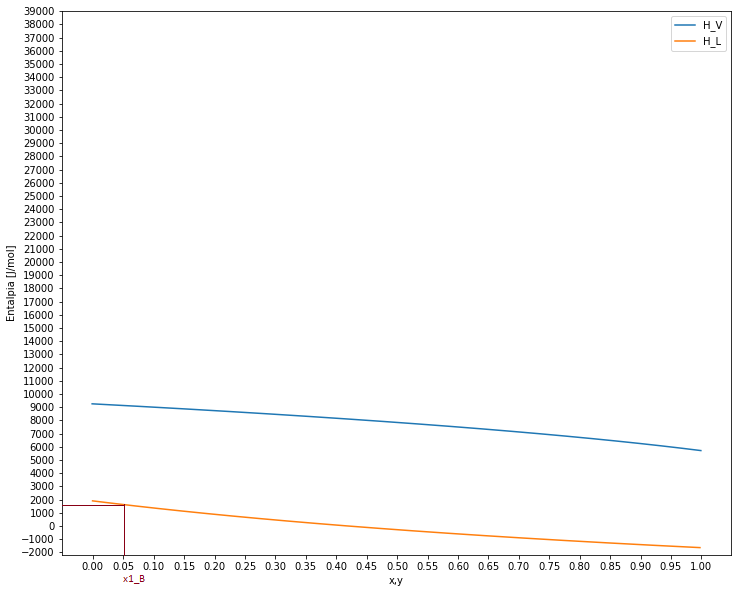

In [ ]:
Hb_L = 1900 #J/mol

In [ ]:
qk = -B*(Pb - Hb_L)
qk

467500.0

## Parte 8: Verificação do BEG

Para isso iremos utilizar as equações:

$F \cdot H_F + q_k = q_c +D \cdot H_D + B \cdot H_B  $

$H_D = H_D^L$

$H_B = H_B^L$

In [ ]:
parte_1 = F*HF + qk
parte_1

628750.0

In [ ]:
parte_2 = qc + D*Hd_l + B*Hb_L
parte_2

624800.1104864608

In [ ]:
parte_2 - parte_1

-3949.8895135391504

Observamos que o BMG não está fechando corretamente já que há uma diferença de aproximadamente 3949.88 J advindas do primeiro termo. Isso pode indicar um erro associado a formação do gráfico com defasagem de escala ou até mesmo em alguma conta utilizada na hora do balanço. 

## Parte 9: Comparação entre os métodos:

Comparação feita através da AVS03 e AVS04.

|Fator       | McCabe-Thiele | Ponchon-Savarit|
|:----------:|:-------------:|:--------------:|
|$$RD_{min}$$|     1.63      |       1.98     |
|NETS        |      12       |       11       |
|Est.Alimentação|       6    |        6       | 